<a href="https://colab.research.google.com/github/dolmani38/non-linear-regression/blob/master/Regession_test_0712.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lime import lime_tabular, lime_text
from keras.utils import to_categorical
import datetime
import random

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

np.random.seed(1234567890)

from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def soft_100_acc(y_true, y_pred):
    delta = 100
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_300_acc(y_true, y_pred):
    delta = 300
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def structure(df):
    """
    DataFrame의 column 등 전반적인 구조를 표출 한다.
    :param df:
    :return:
    """
    df1 = df.describe(include='all').T
    df1['type'] = df.dtypes
    df1['null count'] = df.isnull().sum()
    if 'freq' in df1.columns:
        df2 = df1[
            ['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'unique', 'top',
             'freq']]
    else:
        df2 = df1[['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

    return df2

class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else str(log).strip())),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100):
        self.display = display

    def on_train_begin(self, logs={}):      
        self.epochs = 0    

    def on_epoch_end(self, batch, logs={}):    
        self.epochs += 1     
        if self.epochs % self.display == 0:
            print ("Epoch: %d - %s" % (self.epochs, str(logs)))
 
periodic_logger_50 = PeriodicLogger(50)
periodic_logger_250 = PeriodicLogger(250)
periodic_logger_1000 = PeriodicLogger(1000)

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=b3132be577cf71c5657156bc9877b1521ad0cff77a18234eecd35ddf4047bea0
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


Using TensorFlow backend.


In [71]:
per_meter_mapping = {
    'Mercaz': 500,
    'Old North': 350,
    'Florentine': 230
}

per_room_additional_price = {
    'Mercaz': 15. * 10**4,
    'Old North': 8. * 10**4,
    'Florentine': 5. * 10**4
}

per_type_price = {
    'fullsize': 3,
    'economy': 1.2,
    'convertible': 9,
    'standard': 2.5,
    'premium': 4,
    'intermediate': 2,
    'luxury': 12,
    'compact': 1.5
}

def house_price_func(row):
    """
    house_price_func is the function f(a,s,n).
    
    :param row: dict (contains the keys: ['area', 'size', 'n_rooms'])
    :return: float
    """
    date, ver,rate,area, size, n_rooms, ctype = row['date'],row['ver'],row['rate'], row['area'], row['size'], row['n_rooms'], row['ctype']
  
    return (size * per_meter_mapping[area] - 120)*rate + (n_rooms*n_rooms)/4 * per_room_additional_price[area] * per_type_price[ctype]

In [209]:
AREAS = ['Mercaz', 'Old North', 'Florentine']
HOUSE_TYPE = ['economy','compact','intermediate','standard','fullsize','premium','luxury','convertible']

def create_samples(n_samples):
    """
    Helper method that creates dataset DataFrames
    
    Note that the np.random.choice call only determines the number of rooms and the size of the house
    (the price, which we calculate later, is deterministic)
    
    :param n_samples: int (number of samples for each area (suburb))
    :return: pd.DataFrame


    """
    date = datetime.date(2010, 4, 13)
    samples = []
    ver = 1
    rate = 1
    for i in range(n_samples):
        if random.choices(range(120*5)) == [1]:
            date += datetime.timedelta(days=1)
            if date >= datetime.date(2010,4,18):
                rate = 0.90
                ver=2
            if date >= datetime.date(2010,4,22):
                rate = 0.46
                ver=3
            if date >= datetime.date(2010,5,10):
                rate = 0.80
                ver=4
            if date >= datetime.date(2010,5,14):
                rate = 0.95
                ver=5
            if date >= datetime.date(2010,5,20):
                rate = 0.88
                ver=6
            if date >= datetime.date(2010,5,22):
                rate = 0.65
                ver=7
            if date >= datetime.date(2010,6,1):
                rate = 1.00
                ver=8
            if date >= datetime.date(2010,6,5):
                rate = 0.81    
                ver=9

        samples.append([date,ver,rate, np.random.choice(AREAS), int(np.random.normal(25, 5)),int(np.random.normal(300, 50)), np.random.choice(range(1, 6)),np.random.choice(HOUSE_TYPE)])
        
    return pd.DataFrame(samples, columns=['date','ver','rate','area', 'size', 'lamp', 'n_rooms','ctype'])

In [210]:
dataset = create_samples(n_samples=50000)
dataset['price'] = dataset.apply(house_price_func, axis=1)

In [211]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
date,object,50000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,2010-06-07,2790
ver,int64,50000,0,6.42908,2.75997,1,3,8,9,9,NaN,NaN,NaN
rate,float64,50000,0,0.780237,0.176779,0.46,0.8,0.81,0.9,1,NaN,NaN,NaN
area,object,50000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Old North,16770
size,int64,50000,0,24.5108,5.02256,3,21,25,28,45,NaN,NaN,NaN
lamp,int64,50000,0,299.205,49.7574,106,266,299,333,509,NaN,NaN,NaN
n_rooms,int64,50000,0,2.99472,1.41319,1,2,3,4,5,NaN,NaN,NaN
ctype,object,50000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,standard,6336
price,float64,50000,0,1.12251e+06,1.68557e+06,16320.2,174242,488919,1.3527e+06,1.12689e+07,NaN,NaN,NaN


In [212]:
# dataset의 파생변수 생성
dataset['size_n_rooms'] = dataset['size'] * dataset['n_rooms']
dataset['size_size'] = dataset['size'] * dataset['size']
dataset['n_rooms_n_rooms'] = dataset['n_rooms'] * dataset['n_rooms']

In [213]:
# zscore norm

ds = dataset[['rate','size','lamp','n_rooms','size_n_rooms','size_size','n_rooms_n_rooms']]

_mean = ds.mean(axis=0)
_std = ds.std(axis=0)

ds = ds - _mean
ds /= _std

dataset.update(ds)
dataset

,date,ver,rate,area,size,lamp,n_rooms,ctype,price,size_n_rooms,size_size,n_rooms_n_rooms
0,2010-04-13,1,1.243150,Old North,-0.499908,-0.124710,-1.411507,intermediate,47580.0,-1.334188,-0.571589,-1.154310
1,2010-04-13,1,1.243150,Mercaz,-2.092720,-0.546758,-1.411507,economy,51880.0,-1.541662,-1.730819,-1.154310
2,2010-04-13,1,1.243150,Mercaz,1.889310,-0.627148,-1.411507,compact,73130.0,-1.022978,2.133281,-1.154310
3,2010-04-13,1,1.243150,Florentine,1.292005,-0.044320,0.711358,convertible,1807010.0,1.311097,1.348386,0.583167
4,2010-04-13,1,1.243150,Old North,0.694701,0.839970,1.418979,fullsize,1509680.0,1.726044,0.635943,1.625652
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2010-07-03,9,0.168362,Mercaz,-0.300807,0.779678,0.711358,intermediate,1209217.8,0.481204,-0.390459,0.583167
49996,2010-07-03,9,0.168362,Florentine,-0.499908,-0.747733,0.003736,economy,139001.4,-0.193085,-0.571589,-0.227656
49997,2010-07-03,9,0.168362,Old North,0.296498,0.156655,-1.411507,convertible,187273.8,-1.230452,0.201231,-1.154310
49998,2010-07-03,9,0.168362,Mercaz,-1.097213,-0.446270,0.711358,luxury,7207597.8,0.066257,-1.066677,0.583167


In [177]:
class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values

In [214]:
vers_mapping = EmbeddingMapping(dataset['ver'])
area_mapping = EmbeddingMapping(dataset['area'])
type_mapping = EmbeddingMapping(dataset['ctype'])
date_mapping = EmbeddingMapping(dataset['date'])

dataset = dataset.assign(vers_mapping=dataset['ver'].apply(vers_mapping.get_mapping))
dataset = dataset.assign(area_mapping=dataset['area'].apply(area_mapping.get_mapping))
dataset = dataset.assign(type_mapping=dataset['ctype'].apply(type_mapping.get_mapping))
dataset = dataset.assign(date_mapping=dataset['date'].apply(date_mapping.get_mapping))
dataset

,date,ver,rate,area,size,lamp,n_rooms,ctype,price,size_n_rooms,size_size,n_rooms_n_rooms,vers_mapping,area_mapping,type_mapping,date_mapping
0,2010-04-13,1,1.243150,Old North,-0.499908,-0.124710,-1.411507,intermediate,47580.0,-1.334188,-0.571589,-1.154310,1,1,1,1
1,2010-04-13,1,1.243150,Mercaz,-2.092720,-0.546758,-1.411507,economy,51880.0,-1.541662,-1.730819,-1.154310,1,2,2,1
2,2010-04-13,1,1.243150,Mercaz,1.889310,-0.627148,-1.411507,compact,73130.0,-1.022978,2.133281,-1.154310,1,2,3,1
3,2010-04-13,1,1.243150,Florentine,1.292005,-0.044320,0.711358,convertible,1807010.0,1.311097,1.348386,0.583167,1,3,4,1
4,2010-04-13,1,1.243150,Old North,0.694701,0.839970,1.418979,fullsize,1509680.0,1.726044,0.635943,1.625652,1,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2010-07-03,9,0.168362,Mercaz,-0.300807,0.779678,0.711358,intermediate,1209217.8,0.481204,-0.390459,0.583167,9,2,1,82
49996,2010-07-03,9,0.168362,Florentine,-0.499908,-0.747733,0.003736,economy,139001.4,-0.193085,-0.571589,-0.227656,9,3,2,82
49997,2010-07-03,9,0.168362,Old North,0.296498,0.156655,-1.411507,convertible,187273.8,-1.230452,0.201231,-1.154310,9,1,4,82
49998,2010-07-03,9,0.168362,Mercaz,-1.097213,-0.446270,0.711358,luxury,7207597.8,0.066257,-1.066677,0.583167,9,2,8,82


In [129]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['rate','size','lamp','n_rooms','size_n_rooms','size_size','n_rooms_n_rooms','vers_mapping','area_mapping','type_mapping','date_mapping']],
    dataset['price'], test_size=0.1, random_state=0)


X_train_continuous_org = X_train_org[['size','lamp','n_rooms','size_n_rooms','size_size','n_rooms_n_rooms']]
X_train_categorical_org = X_train_org[['vers_mapping', 'area_mapping','type_mapping']]

X_val_continuous_org = X_val_org[['size','lamp','n_rooms','size_n_rooms','size_size','n_rooms_n_rooms']]
X_val_categorical_org = X_val_org[['vers_mapping', 'area_mapping','type_mapping']]

# 학습 대상 변수만 선택
X_train_continuous = X_train_continuous_org[['size','n_rooms','n_rooms_n_rooms']]
X_train_categorical = X_train_categorical_org

X_val_continuous  = X_val_continuous_org[['size','n_rooms','n_rooms_n_rooms']]
X_val_categorical = X_val_categorical_org


In [130]:
# Define the embedding input
area_input = Input(shape=(1,), dtype='int32') 
output_dim=X_train_categorical['area_mapping'].max()*8
area_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['area_mapping'].max()+1)(area_input)
area_embedings = keras.layers.Reshape((output_dim,))(area_embedings)

type_input = Input(shape=(1,), dtype='int32') 
output_dim=X_train_categorical['type_mapping'].max()*8
type_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['type_mapping'].max()+1)(type_input)
type_embedings = keras.layers.Reshape((output_dim,))(type_embedings)

vers_input = Input(shape=(1,), dtype='int32') 
output_dim=X_train_categorical['vers_mapping'].max()*8
vers_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['vers_mapping'].max()+1)(vers_input)
vers_embedings = keras.layers.Reshape((output_dim,))(vers_embedings)

print(area_embedings)
print(type_embedings)
print(vers_embedings)


Tensor("reshape_38/Reshape:0", shape=(None, 24), dtype=float32)
Tensor("reshape_39/Reshape:0", shape=(None, 64), dtype=float32)
Tensor("reshape_40/Reshape:0", shape=(None, 72), dtype=float32)


In [131]:
# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, area_embedings, type_embedings, vers_embedings])
print(all_input)

Tensor("concatenate_17/concat:0", shape=(None, 163), dtype=float32)


In [132]:
# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, area_input,type_input, vers_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_100_acc,soft_300_acc,r2])
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_55 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_56 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 1, 24)        96          input_54[0][0]                   
___________________________________________________________________________________________

In [133]:
epochs = 1000

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['area_mapping'],X_train_categorical['type_mapping'],X_train_categorical['vers_mapping']], Y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_50], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['area_mapping'],X_val_categorical['type_mapping'],X_val_categorical['vers_mapping']], Y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 50 - {'val_loss': 507077.58525, 'val_soft_100_acc': 0.16781851649284363, 'val_soft_300_acc': 0.4234525263309479, 'val_r2': 0.9999998807907104, 'loss': 438442.2251111111, 'soft_100_acc': 0.15387323, 'soft_300_acc': 0.44027287, 'r2': 0.9999999}
Epoch: 100 - {'val_loss': 306078.147, 'val_soft_100_acc': 0.19448617100715637, 'val_soft_300_acc': 0.5597205758094788, 'val_r2': 0.9999999403953552, 'loss': 265428.31091666664, 'soft_100_acc': 0.2109375, 'soft_300_acc': 0.54515845, 'r2': 0.9999999}
Epoch: 150 - {'val_loss': 255653.3185, 'val_soft_100_acc': 0.2466195970773697, 'val_soft_300_acc': 0.6043419241905212, 'val_r2': 0.9999999403953552, 'loss': 222376.64190277777, 'soft_100_acc': 0.23239437, 'soft_300_acc': 0.58919454, 'r2': 0.9999999}
Epoch: 200 - {'val_loss': 237265.021375, 'val_soft_100_acc': 0.2588641941547394, 'val_soft_300_acc': 0.62109375, 'val_r2': 0.9999999403953552, 'loss': 197864.36844444444, 'soft_100_acc': 0.25343308, 'soft_300_acc': 0.61520684, 'r2': 0.9999999}
Epoch: 

In [138]:
# Define the embedding input
cate_input = Input(shape=(3,), dtype='int32') 
output_dim=24*3
input_dim = X_train_categorical['vers_mapping'].max()*X_train_categorical['area_mapping'].max()* X_train_categorical['type_mapping'].max() + 1
cate_embedings = Embedding(output_dim=output_dim, input_dim=input_dim)(cate_input)
cate_embedings = keras.layers.Reshape((output_dim*3,))(cate_embedings)
print(cate_embedings)

Tensor("reshape_42/Reshape:0", shape=(None, 216), dtype=float32)


In [139]:
# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, cate_embedings])
print(all_input)

Tensor("concatenate_19/concat:0", shape=(None, 219), dtype=float32)


In [140]:
# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, cate_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_100_acc,soft_300_acc,r2])
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           (None, 3)            0                                            
__________________________________________________________________________________________________
embedding_42 (Embedding)        (None, 3, 72)        15624       input_60[0][0]                   
__________________________________________________________________________________________________
input_61 (InputLayer)           (None, 3)            0                                            
__________________________________________________________________________________________________
reshape_42 (Reshape)            (None, 216)          0           embedding_42[0][0]               
___________________________________________________________________________________________

In [141]:
epochs = 1000

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical], Y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_50], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical], Y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 50 - {'val_loss': 493255.2025, 'val_soft_100_acc': 0.17149940133094788, 'val_soft_300_acc': 0.4887319803237915, 'val_r2': 0.9999998807907104, 'loss': 382344.5814444444, 'soft_100_acc': 0.18074383, 'soft_300_acc': 0.48413292, 'r2': 0.9999999}
Epoch: 100 - {'val_loss': 344400.983375, 'val_soft_100_acc': 0.2104116678237915, 'val_soft_300_acc': 0.5696364045143127, 'val_r2': 0.9999998807907104, 'loss': 179432.0566111111, 'soft_100_acc': 0.26168573, 'soft_300_acc': 0.6509023, 'r2': 0.9999999}
Epoch: 150 - {'val_loss': 280518.864875, 'val_soft_100_acc': 0.25075119733810425, 'val_soft_300_acc': 0.6379206776618958, 'val_r2': 0.9999999403953552, 'loss': 144637.48634722224, 'soft_100_acc': 0.29817343, 'soft_300_acc': 0.69205546, 'r2': 0.9999999}
Epoch: 200 - {'val_loss': 249559.54325, 'val_soft_100_acc': 0.2816255986690521, 'val_soft_300_acc': 0.669921875, 'val_r2': 0.9999999403953552, 'loss': 128828.44591666666, 'soft_100_acc': 0.31102553, 'soft_300_acc': 0.7131822, 'r2': 1.0}
Epoch: 250 

In [215]:
dataset_vers_mapping = pd.DataFrame(to_categorical(dataset['vers_mapping']-1),columns=['vers_' + str(s) for s in range(dataset['vers_mapping'].max())])
dataset_area_mapping = pd.DataFrame(to_categorical(dataset['area_mapping']-1),columns=['area_' + s for s in AREAS])
dataset_type_mapping = pd.DataFrame(to_categorical(dataset['type_mapping']-1),columns=['type_' + s for s in HOUSE_TYPE])

#dataset = pd.concat([dataset,dataset_vers_mapping,dataset_area_mapping,dataset_type_mapping], axis=1)

In [216]:
#  추가 파생변수 생성
dataset_size_vers_mapping = dataset_vers_mapping.multiply(dataset['size'], axis=0)
dataset_n_rooms_vers_mapping = dataset_vers_mapping.multiply(dataset['n_rooms'], axis=0)
dataset_size_vers_mapping.rename(columns={'vers_' + str(s):'size_vers_'+str(s) for s in range(dataset['vers_mapping'].max())}, inplace=True)
dataset_n_rooms_vers_mapping.rename(columns={'vers_' + str(s):'n_rooms_vers_'+str(s) for s in range(dataset['vers_mapping'].max())}, inplace=True)

dataset_size_area_mapping = dataset_area_mapping.multiply(dataset['size'], axis=0)
dataset_n_rooms_area_mapping = dataset_area_mapping.multiply(dataset['n_rooms'], axis=0)
dataset_size_area_mapping.rename(columns={'area_' + s:'size_area_'+s for s in AREAS}, inplace=True)
dataset_n_rooms_area_mapping.rename(columns={'area_' + s:'n_rooms_area_'+s for s in AREAS}, inplace=True)

dataset_size_type_mapping = dataset_type_mapping.multiply(dataset['size'], axis=0)
dataset_n_rooms_type_mapping = dataset_type_mapping.multiply(dataset['n_rooms'], axis=0)
dataset_size_type_mapping.rename(columns={'type_' + s:'size_type_'+s for s in HOUSE_TYPE}, inplace=True)
dataset_n_rooms_type_mapping.rename(columns={'type_' + s:'n_rooms_type_'+s for s in HOUSE_TYPE}, inplace=True)

In [217]:
dataset = pd.concat([dataset,dataset_size_vers_mapping,dataset_n_rooms_vers_mapping,dataset_size_area_mapping,dataset_n_rooms_area_mapping,dataset_size_type_mapping,dataset_n_rooms_type_mapping], axis=1)

In [218]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
date,object,50000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,2010-06-07,2790
ver,int64,50000,0,6.42908,2.75997,1,3,8,9,9,NaN,NaN,NaN
rate,float64,50000,0,-1.15762e-14,1,-1.81151,0.111794,0.168362,0.677472,1.24315,NaN,NaN,NaN
area,object,50000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Old North,16770
size,float64,50000,0,5.10696e-16,1,-4.28284,-0.69901,0.0973965,0.694701,4.07943,NaN,NaN,NaN
lamp,float64,50000,0,-2.13414e-16,1,-3.88294,-0.667343,-0.00412521,0.67919,4.21635,NaN,NaN,NaN
n_rooms,float64,50000,0,1.46783e-16,1,-1.41151,-0.703885,0.00373624,0.711358,1.41898,NaN,NaN,NaN
ctype,object,50000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,standard,6336
price,float64,50000,0,1.12251e+06,1.68557e+06,16320.2,174242,488919,1.3527e+06,1.12689e+07,NaN,NaN,NaN
size_n_rooms,float64,50000,0,-1.79049e-16,1,-1.74913,-0.815505,-0.115282,0.688677,3.67111,NaN,NaN,NaN


In [219]:
# trainset과 validationset 나누고... 기타 정리

columns = list(dataset.columns)
for a in ['date','ver','rate','area','ctype','lamp','price','size_n_rooms','size_size']:
  columns.remove(a)

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[columns],
    dataset['price'], test_size=0.1, random_state=0)

columns.remove('date_mapping')
columns.remove('area_mapping')
columns.remove('type_mapping')
columns.remove('vers_mapping')

X_train_continuous = X_train_org[columns]
X_train_categorical = X_train_org[['vers_mapping','area_mapping','type_mapping']]

X_val_continuous = X_val_org[columns]
X_val_categorical = X_val_org[['vers_mapping','area_mapping','type_mapping']]


In [220]:
structure(X_train_continuous)

,type,count,null count,mean,std,min,25%,50%,75%,max
size,float64,45000.0,0,0.001191,1.001886,-4.282837,-0.699010,0.097396,0.694701,4.079427
n_rooms,float64,45000.0,0,0.000025,0.999586,-1.411507,-0.703885,0.003736,0.711358,1.418979
n_rooms_n_rooms,float64,45000.0,0,-0.000167,0.999772,-1.154310,-0.806815,-0.227656,0.583167,1.625652
size_vers_0,float64,45000.0,0,-0.000007,0.219890,-3.486431,0.000000,0.000000,0.000000,3.681223
size_vers_1,float64,45000.0,0,-0.001112,0.138533,-3.486431,0.000000,0.000000,0.000000,2.884817
size_vers_2,float64,45000.0,0,-0.001785,0.432533,-3.685532,0.000000,-0.000000,0.000000,3.880325
size_vers_3,float64,45000.0,0,-0.000534,0.265893,-3.088228,-0.000000,0.000000,0.000000,3.681223
size_vers_4,float64,45000.0,0,0.000673,0.296335,-4.282837,0.000000,-0.000000,-0.000000,4.079427
size_vers_5,float64,45000.0,0,0.000909,0.085058,-2.490923,-0.000000,0.000000,0.000000,3.482122
size_vers_6,float64,45000.0,0,-0.000117,0.211741,-3.287329,0.000000,0.000000,0.000000,2.884817


In [189]:
X_train_continuous

,size,n_rooms,n_rooms_n_rooms,vers_0,vers_1,vers_2,vers_3,vers_4,vers_5,vers_6,vers_7,vers_8,area_Mercaz,area_Old North,area_Florentine,type_economy,type_compact,type_intermediate,type_standard,type_fullsize,type_premium,type_luxury,type_convertible,size_vers_0,size_vers_1,size_vers_2,size_vers_3,size_vers_4,size_vers_5,size_vers_6,size_vers_7,size_vers_8,n_rooms_vers_0,n_rooms_vers_1,n_rooms_vers_2,n_rooms_vers_3,n_rooms_vers_4,n_rooms_vers_5,n_rooms_vers_6,n_rooms_vers_7,n_rooms_vers_8,size_area_Mercaz,size_area_Old North,size_area_Florentine,n_rooms_area_Mercaz,n_rooms_area_Old North,n_rooms_area_Florentine,size_type_economy,size_type_compact,size_type_intermediate,size_type_standard,size_type_fullsize,size_type_premium,size_type_luxury,size_type_convertible,n_rooms_type_economy,n_rooms_type_compact,n_rooms_type_intermediate,n_rooms_type_standard,n_rooms_type_fullsize,n_rooms_type_premium,n_rooms_type_luxury,n_rooms_type_convertible
1554,1.098176,-1.400435,-1.147879,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098176,0.000000,0.000000,0.0,0.0,0.000000,0.000000,-0.0,-0.0,-1.400435,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.000000,1.098176,0.000000,0.000000,-1.400435,-0.000000,-0.000000,0.000000,1.098176,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.000000,-1.400435,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
2087,0.700588,1.406611,1.605929,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.700588,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.406611,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.700588,0.000000,0.000000,1.406611,0.000000,0.700588,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.406611,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
5470,0.700588,-0.698674,-0.803653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.700588,-0.0,-0.0,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.698674,0.000000,0.000000,0.700588,-0.000000,-0.000000,-0.698674,0.700588,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.698674,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
2363,1.296969,0.704849,0.573251,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.296969,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.704849,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.296969,0.000000,0.000000,0.704849,0.000000,0.000000,0.000000,0.000000,0.0,1.296969,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.704849,0.000000,0.000000,0.000000,0.0
7570,0.104208,-0.698674,-0.803653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.104208,-0.0,-0.0,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.698674,0.000000,0.000000,0.104208,-0.000000,-0.000000,-0.698674,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.104208,0.0,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.698674,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9225,-0.094586,0.003088,-0.229943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.0,-0.0,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.094586,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.003088,-0.000000,-0.000000,-0.094586,0.000000,0.000000,0.003088,-0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.094586,-0.000000,-0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.003088,0.000000,0.0
4859,2.092144,0.003088,-0.229943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,2.092144,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.003088,0.000000

In [221]:
# Define the embedding input
cate_input = Input(shape=(3,), dtype='int32') 
output_dim=24*3
input_dim = X_train_categorical['vers_mapping'].max()* X_train_categorical['area_mapping'].max()*X_train_categorical['type_mapping'].max() + 1
cate_embedings = Embedding(output_dim=output_dim, input_dim=input_dim)(cate_input)
cate_embedings = keras.layers.Reshape((output_dim*3,))(cate_embedings)
print(cate_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, cate_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, cate_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_100_acc,soft_300_acc,r2])
model.summary()


Tensor("reshape_49/Reshape:0", shape=(None, 216), dtype=float32)
Tensor("concatenate_26/concat:0", shape=(None, 259), dtype=float32)
Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_75 (InputLayer)           (None, 3)            0                                            
__________________________________________________________________________________________________
embedding_49 (Embedding)        (None, 3, 72)        15624       input_75[0][0]                   
__________________________________________________________________________________________________
input_76 (InputLayer)           (None, 43)           0                                            
__________________________________________________________________________________________________
reshape_49 (Reshape)            (None, 216)          0   

In [222]:
epochs = 1000

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical], Y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_50], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical], Y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 50 - {'val_loss': 413321.1038, 'val_soft_100_acc': 0.294921875, 'val_soft_300_acc': 0.682421863079071, 'val_r2': 0.9999998211860657, 'loss': 334444.1134527778, 'soft_100_acc': 0.30127448, 'soft_300_acc': 0.6757196, 'r2': 0.99999994}
Epoch: 100 - {'val_loss': 289944.9074, 'val_soft_100_acc': 0.38007813692092896, 'val_soft_300_acc': 0.7646484375, 'val_r2': 0.9999998807907104, 'loss': 205513.00643333333, 'soft_100_acc': 0.3798606, 'soft_300_acc': 0.7604093, 'r2': 1.0}
Epoch: 150 - {'val_loss': 243408.6396, 'val_soft_100_acc': 0.43535155057907104, 'val_soft_300_acc': 0.7972656488418579, 'val_r2': 0.9999998807907104, 'loss': 163212.48256666667, 'soft_100_acc': 0.42122146, 'soft_300_acc': 0.79043615, 'r2': 0.99999994}
Epoch: 200 - {'val_loss': 218757.6782, 'val_soft_100_acc': 0.4404296875, 'val_soft_300_acc': 0.8050781488418579, 'val_r2': 0.9999998807907104, 'loss': 141327.0998111111, 'soft_100_acc': 0.4486047, 'soft_300_acc': 0.8088502, 'r2': 1.0}
Epoch: 250 - {'val_loss': 199671.937

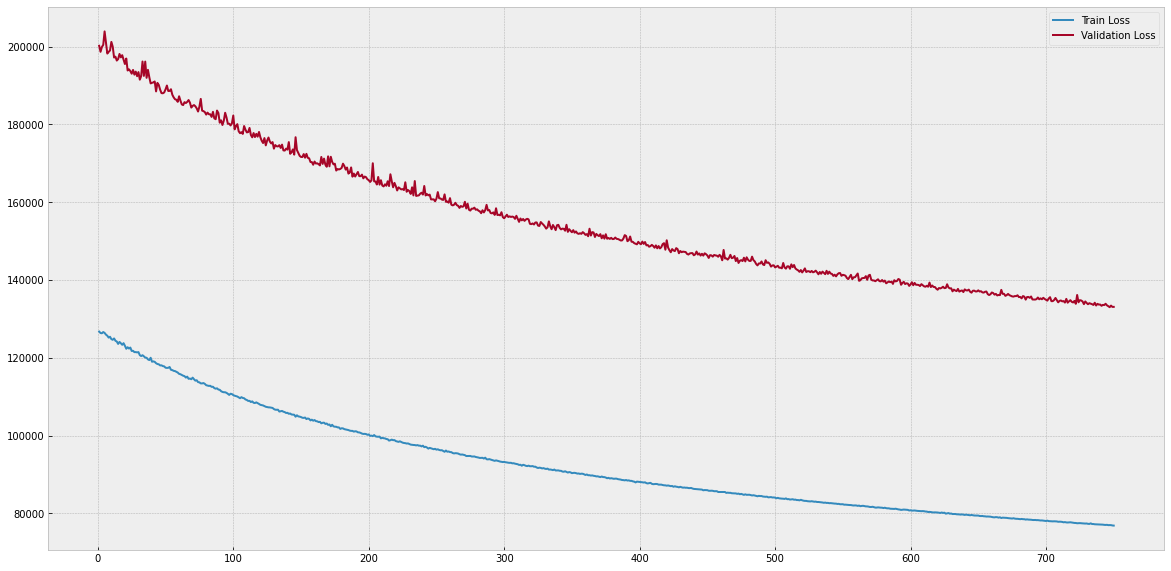

In [223]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][250:]
_val_loss = history.history['val_loss'][250:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 1138106
The mean is very close to 0 (3.71) with std. 364.81.


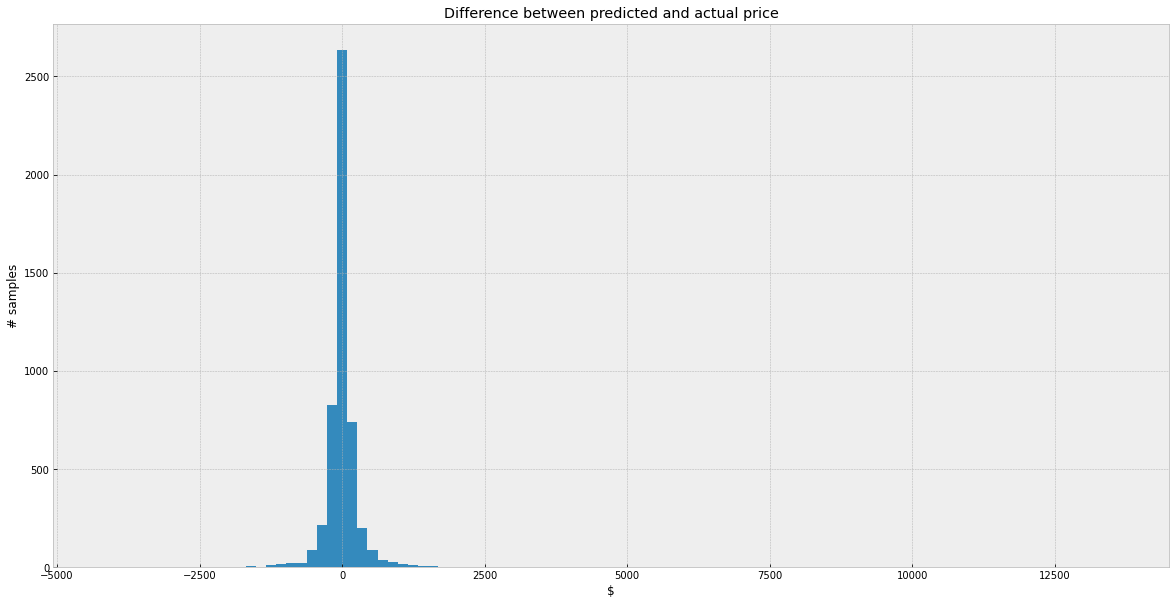

,pred,diff,abs_diff,%diff,abs_%diff,date,ver,rate,area,size,lamp,n_rooms,ctype,price,size_n_rooms,size_size,n_rooms_n_rooms,vers_mapping,area_mapping,type_mapping,date_mapping,size_vers_0,size_vers_1,size_vers_2,size_vers_3,size_vers_4,size_vers_5,size_vers_6,size_vers_7,size_vers_8,n_rooms_vers_0,n_rooms_vers_1,n_rooms_vers_2,n_rooms_vers_3,n_rooms_vers_4,n_rooms_vers_5,n_rooms_vers_6,n_rooms_vers_7,n_rooms_vers_8,size_area_Mercaz,size_area_Old North,size_area_Florentine,n_rooms_area_Mercaz,n_rooms_area_Old North,n_rooms_area_Florentine,size_type_economy,size_type_compact,size_type_intermediate,size_type_standard,size_type_fullsize,size_type_premium,size_type_luxury,size_type_convertible,n_rooms_type_economy,n_rooms_type_compact,n_rooms_type_intermediate,n_rooms_type_standard,n_rooms_type_fullsize,n_rooms_type_premium,n_rooms_type_luxury,n_rooms_type_convertible
20842,7.223627e+06,13612.600000,13612.600000,0.188801,0.188801,2010-05-20,6,0.564336,Mercaz,-0.300807,1.241920,0.711358,luxury,7210014.4,0.481204,-0.390459,0.583167,6,2,8,38,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.300807,-0.0,-0.000000,-0.000000,0.0,0.000000,0.0,0.0,0.0,0.711358,0.0,0.000000,0.000000,-0.000000,-0.300807,-0.000000,0.000000,0.711358,0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.300807,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.711358
2616,7.219686e+06,5393.500000,5393.500000,0.074761,0.074761,2010-04-18,2,0.677472,Mercaz,1.491107,-0.908513,0.711358,luxury,7214292.0,1.414834,1.601968,0.583167,2,2,8,6,0.0,1.491107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.711358,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.491107,0.000000,0.000000,0.711358,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.491107,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.711358
20949,1.623720e+06,-4182.150000,4182.150000,-0.256904,0.256904,2010-05-21,6,0.564336,Old North,0.296498,0.015972,0.003736,convertible,1627902.4,0.118125,0.201231,-0.227656,6,1,4,39,0.0,0.000000,0.0,0.0,0.0,0.296498,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.003736,0.0,0.000000,0.000000,0.296498,0.000000,0.000000,0.003736,0.000000,0.000000,0.0,0.000000,0.000000,0.296498,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.003736,0.000000,0.0,0.0,0.000000
20883,1.139806e+06,3911.600000,3911.600000,0.344363,0.344363,2010-05-20,6,0.564336,Mercaz,0.097396,0.417922,1.418979,economy,1135894.4,1.337032,-0.004049,1.625652,6,2,2,38,0.0,0.000000,0.0,0.0,0.0,0.097396,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.418979,0.0,0.000000,0.000000,0.000000,0.097396,0.000000,0.000000,1.418979,0.000000,0.0,0.097396,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.418979,0.000000,0.000000,0.000000,0.0,0.0,0.000000
36125,3.057879e+06,3465.950000,3465.950000,0.113474,0.113474,2010-06-10,9,0.168362,Mercaz,3.482122,-0.084515,0.003736,convertible,3054412.8,1.362966,4.580545,-0.227656,9,2,4,59,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,3.482122,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.003736,0.000000,3.482122,0.000000,0.000000,0.003736,0.000000,0.0,0.000000,0.000000,3.482122,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.003736,0.000000,0.0,0.0,0.000000
25822,4.506028e+06,3348.000000,3348.000000,0.074356,0.074356,2010-06-02,8,1.243150,Old North,-3.287329,0.920360,1.418979,convertible,4502680.0,-0.867373,-2.262132,1.625652,8,1,4,51,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-3.287329,-0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.418979,0.000000,-3.287329,-0.000000,-0.000000,1.418979,0.000000,0.000000,-0.0,-0.000000,-0.000000,-3.287329,-0.000000,-0.0,-0.0,-0.000000,0.0,0.000000,0.000000,1.418979,0.000000,0.0,0.0,0.000000
42192,3.844495e+06,3174.700000,3174.700000,0.082646,0.082646,2010-06-19,9,0.168362,Old North,-3.884634,0.860068,0.711358,luxury,3841320.3,-1.386057,-2.419112,0.583167,9,1,8,68,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.0,-0.000000,-3.884634,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.711358,-3.884634,-0.000000,-0.000000,0.711358,0.000000,0.000

In [224]:
df = pd.DataFrame(Y_val,columns=['price'])

print ("This is the average value we are trying to predict: %d" % df['price'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['price']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['price'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("$")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['price'],inplace=True)
b = a.join(dataset)
b.head(10)

In [225]:
train_ds = pd.concat([X_train_continuous,X_train_categorical], axis=1)
val_ds = pd.concat([X_val_continuous,X_val_categorical], axis=1)

# XAI를 위한 lime  정의
from lime import lime_tabular, lime_text
exp = lime_tabular.LimeTabularExplainer(
    train_ds.to_numpy(),
    training_labels=Y_train,
    feature_names=train_ds.columns,
    class_names= ['price'],
    mode="regression"
)

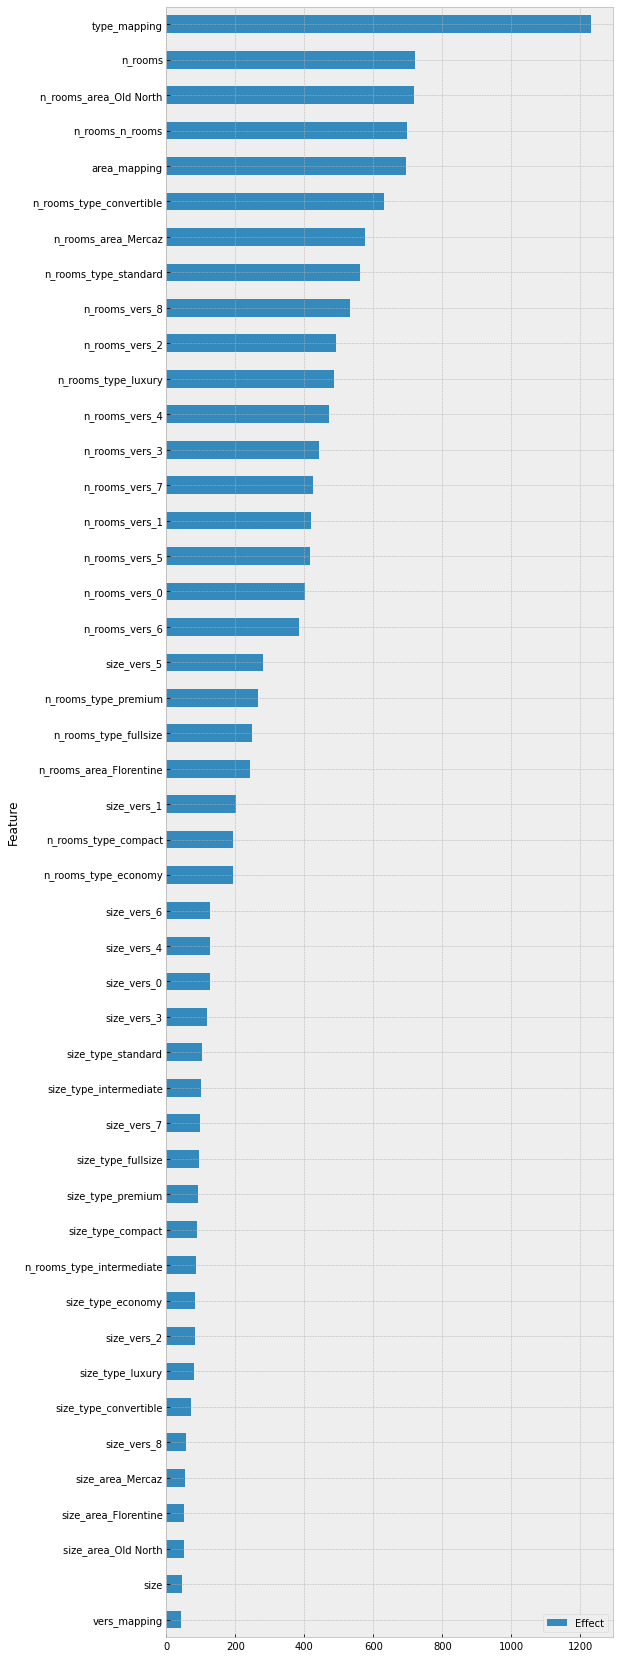

,Feature,Effect
0,vers_mapping,42.946181
1,size,44.096651
2,size_area_Old North,51.640721
3,size_area_Florentine,51.977615
4,size_area_Mercaz,54.687236
5,size_vers_8,57.379979
6,size_type_convertible,72.758714
7,size_type_luxury,80.021277
8,size_vers_2,82.419489
9,size_type_economy,83.473915


In [226]:
# 변수의 영향력 분석
# 소팅을 위한 초기화 
exp_ana = {}
for k in train_ds.columns:
  exp_ana[k] = 0

# predict 함수 재정의 - lime에서 사용 가능하도록...
continue_dim = X_train_continuous.shape[1]
input_dim = train_ds.shape[1]
def predict(data):
    return model.predict([data[:,0:continue_dim],data[:,continue_dim:input_dim]])

# validation set의 변수 영향력 분석...
for i in range(40): #range(val_ds.shape[0]):
    p = exp.explain_instance(np.asarray(val_ds.iloc[i]),predict,num_features=val_ds.shape[1])
    for t in p.as_map()[0]:
      exp_ana[train_ds.columns[t[0]]] += np.abs(t[1])

import operator

sorted_x = sorted(exp_ana.items(), key=operator.itemgetter(1))

effect_result_table = pd.DataFrame(sorted_x,columns=['Feature', 'Effect'])
effect_result_table['Effect'] = effect_result_table['Effect']/10000
effect_result_table.plot(x='Feature',y='Effect', figsize=(8, 30),kind='barh')
plt.show()
effect_result_table

In [228]:
# Define the embedding input
cate_input = Input(shape=(2,), dtype='int32') 
output_dim=24*3
input_dim = X_train_categorical['area_mapping'].max()*X_train_categorical['type_mapping'].max() + 1
cate_embedings = Embedding(output_dim=output_dim, input_dim=input_dim)(cate_input)
cate_embedings = keras.layers.Reshape((output_dim*2,))(cate_embedings)
print(cate_embedings)

# Define the embedding input
date_input = Input(shape=(1,), dtype='int32') 
output_dim=24*3
input_dim = X_train_categorical['vers_mapping'].max() + 1
date_embedings = Embedding(output_dim=output_dim, input_dim=input_dim)(date_input)
date_embedings = keras.layers.Reshape((output_dim,))(date_embedings)
print(date_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, date_embedings, cate_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, date_input, cate_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_100_acc,soft_300_acc,r2])
model.summary()

Tensor("reshape_52/Reshape:0", shape=(None, 144), dtype=float32)
Tensor("reshape_53/Reshape:0", shape=(None, 72), dtype=float32)
Tensor("concatenate_28/concat:0", shape=(None, 259), dtype=float32)
Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_81 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_80 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
embedding_53 (Embedding)        (None, 1, 72)        720         input_81[0][0]                   
____________________________________________________________________________________________

In [232]:
epochs = 3000

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['vers_mapping'],X_train_categorical[['area_mapping','type_mapping']].to_numpy()], Y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_50], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['vers_mapping'],X_val_categorical[['area_mapping','type_mapping']].to_numpy()], Y_val))

Epoch: 50 - {'val_loss': 115716.9354, 'val_soft_100_acc': 0.5960937738418579, 'val_soft_300_acc': 0.8968750238418579, 'val_r2': 1.0, 'loss': 49883.31341041667, 'soft_100_acc': 0.5908129, 'soft_300_acc': 0.9097494, 'r2': 1.0}
Epoch: 100 - {'val_loss': 116728.94385, 'val_soft_100_acc': 0.588671863079071, 'val_soft_300_acc': 0.896484375, 'val_r2': 1.0, 'loss': 49299.02678854167, 'soft_100_acc': 0.59539735, 'soft_300_acc': 0.91075796, 'r2': 1.0}
Epoch: 150 - {'val_loss': 112891.4403, 'val_soft_100_acc': 0.5992187261581421, 'val_soft_300_acc': 0.8994140625, 'val_r2': 1.0, 'loss': 48726.95099444444, 'soft_100_acc': 0.596655, 'soft_300_acc': 0.9116013, 'r2': 1.0}
Epoch: 200 - {'val_loss': 111079.6237, 'val_soft_100_acc': 0.5859375, 'val_soft_300_acc': 0.900585949420929, 'val_r2': 1.0, 'loss': 48213.79560625, 'soft_100_acc': 0.59999657, 'soft_300_acc': 0.9122031, 'r2': 1.0}
Epoch: 250 - {'val_loss': 110440.8442, 'val_soft_100_acc': 0.603515625, 'val_soft_300_acc': 0.902148425579071, 'val_r2': 

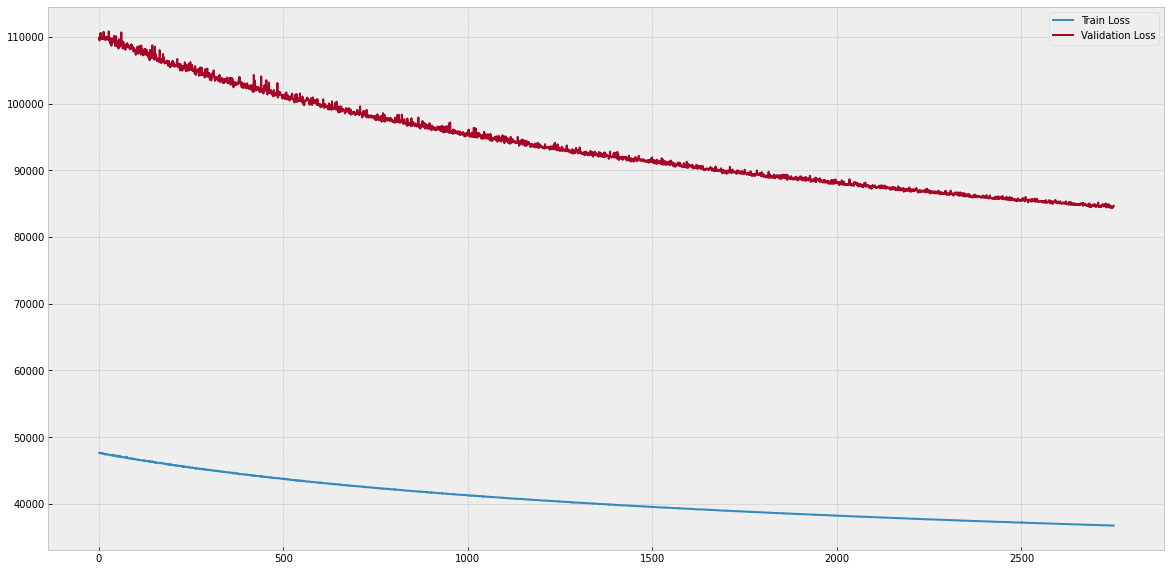

In [233]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][250:]
_val_loss = history.history['val_loss'][250:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

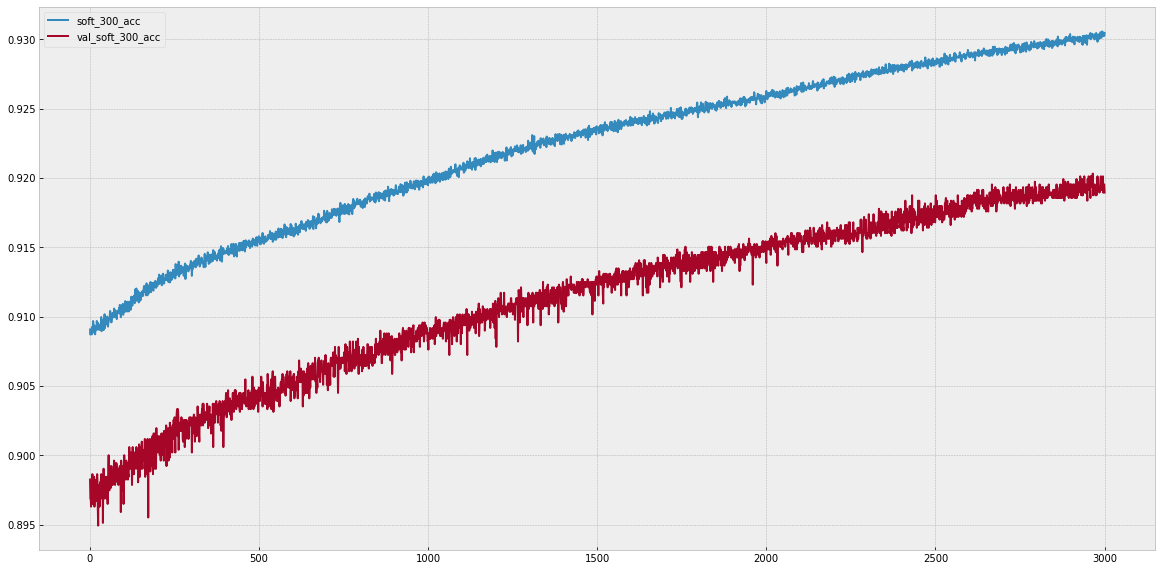

In [237]:
plt.figure(figsize=(20,10))
_loss = history.history['soft_300_acc'][0:]
_val_loss = history.history['val_soft_300_acc'][0:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='soft_300_acc')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='val_soft_300_acc')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 1138106
The mean is very close to 0 (5.81) with std. 290.94.


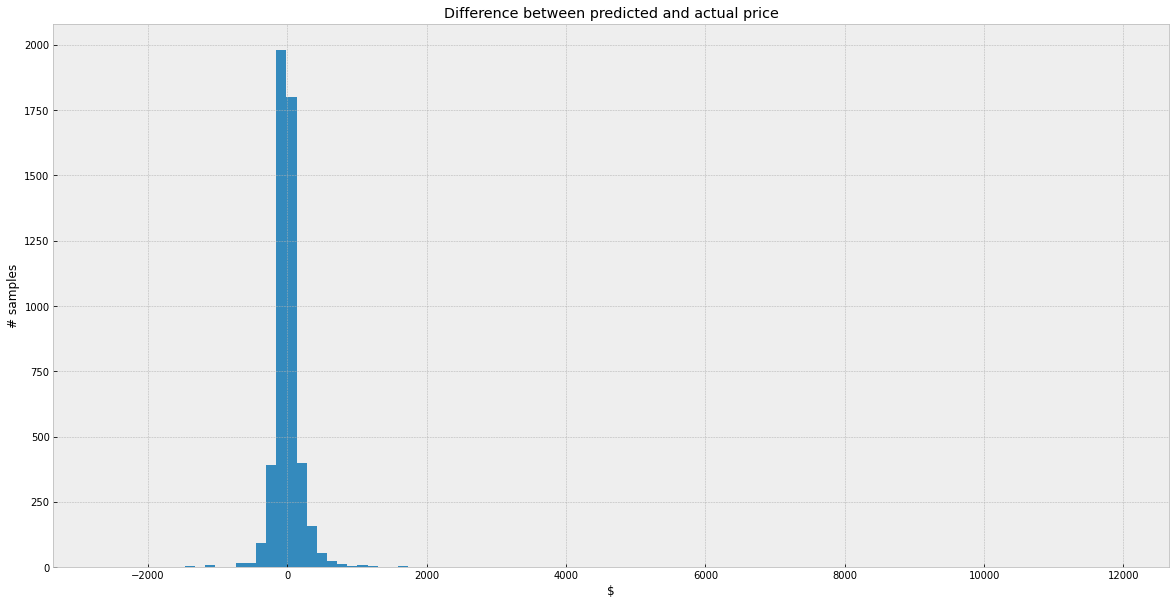

,pred,price,abs_diff,rate,area,ctype,size,n_rooms
20842,7.221941e+06,7210014.4,11926.600000,0.564336,Mercaz,luxury,-0.300807,0.711358
1696,4.063440e+06,4056880.0,6560.500000,1.243150,Mercaz,luxury,-2.092720,0.003736
2616,7.218607e+06,7214292.0,4315.000000,0.677472,Mercaz,luxury,1.491107,0.711358
20789,9.034216e+05,906054.4,2632.775000,0.564336,Mercaz,compact,-2.092720,0.711358
24323,6.006060e+06,6003730.0,2330.000000,1.243150,Old North,luxury,-2.690025,1.418979
1801,4.061210e+06,4058880.0,2330.000000,1.243150,Mercaz,luxury,-1.296314,0.003736
1905,1.809029e+06,1806880.0,2148.625000,1.243150,Mercaz,luxury,-2.092720,-0.703885
12848,6.176129e+05,615504.0,2108.937500,0.111794,Mercaz,premium,2.884817,-0.703885
21873,6.010448e+06,6008567.0,1881.500000,-0.736723,Old North,luxury,2.685716,1.418979
28,4.061210e+06,4059380.0,1829.500000,1.243150,Mercaz,luxury,-1.097213,0.003736


In [241]:
df = pd.DataFrame(Y_val,columns=['price'])

print ("This is the average value we are trying to predict: %d" % df['price'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical['vers_mapping'],X_val_categorical[['area_mapping','type_mapping']].to_numpy()])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['price']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['price'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("$")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['price'],inplace=True)
b = a.join(dataset)
b[['pred','price','abs_diff','rate','area','ctype','size','n_rooms']].head(20)

In [255]:
dataset_rate_size_area_mapping = dataset_size_area_mapping.multiply(dataset['rate'], axis=0)
dataset_rate_size_area_mapping.rename(columns={'size_area_' + s:'rate_size_area_'+s for s in AREAS}, inplace=True)
dataset = pd.concat([dataset,dataset_rate_size_area_mapping], axis=1)

In [263]:
# trainset과 validationset 나누고... 기타 정리

columns = ['size','n_rooms','n_rooms_n_rooms']
columns +=['size_area_' + s for s in AREAS]
columns +=['rate_size_area_' + s for s in AREAS]
columns +=['n_rooms_area_' + s for s in AREAS]
columns +=['size_type_' + s for s in HOUSE_TYPE]
columns +=['n_rooms_type_' + s for s in HOUSE_TYPE]
columns +=['vers_mapping','area_mapping','type_mapping']


columns

['size',
 'n_rooms',
 'n_rooms_n_rooms',
 'size_area_Mercaz',
 'size_area_Old North',
 'size_area_Florentine',
 'rate_size_area_Mercaz',
 'rate_size_area_Old North',
 'rate_size_area_Florentine',
 'n_rooms_area_Mercaz',
 'n_rooms_area_Old North',
 'n_rooms_area_Florentine',
 'size_type_economy',
 'size_type_compact',
 'size_type_intermediate',
 'size_type_standard',
 'size_type_fullsize',
 'size_type_premium',
 'size_type_luxury',
 'size_type_convertible',
 'n_rooms_type_economy',
 'n_rooms_type_compact',
 'n_rooms_type_intermediate',
 'n_rooms_type_standard',
 'n_rooms_type_fullsize',
 'n_rooms_type_premium',
 'n_rooms_type_luxury',
 'n_rooms_type_convertible',
 'vers_mapping',
 'area_mapping',
 'type_mapping']

In [264]:
X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[columns],
    dataset['price'], test_size=0.1, random_state=0)

columns.remove('vers_mapping')
columns.remove('area_mapping')
columns.remove('type_mapping')

X_train_continuous = X_train_org[columns]
X_train_categorical = X_train_org[['vers_mapping','area_mapping','type_mapping']]

X_val_continuous = X_val_org[columns]
X_val_categorical = X_val_org[['vers_mapping','area_mapping','type_mapping']]

In [265]:
# Define the embedding input
cate_input = Input(shape=(2,), dtype='int32') 
output_dim=24*3
input_dim = X_train_categorical['area_mapping'].max()*X_train_categorical['type_mapping'].max() + 1
cate_embedings = Embedding(output_dim=output_dim, input_dim=input_dim)(cate_input)
cate_embedings = keras.layers.Reshape((output_dim*2,))(cate_embedings)
print(cate_embedings)

# Define the embedding input
date_input = Input(shape=(1,), dtype='int32') 
output_dim=24*3
input_dim = X_train_categorical['vers_mapping'].max() + 1
date_embedings = Embedding(output_dim=output_dim, input_dim=input_dim)(date_input)
date_embedings = keras.layers.Reshape((output_dim,))(date_embedings)
print(date_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, date_embedings, cate_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input,date_input, cate_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_100_acc,soft_300_acc,r2])
model.summary()

Tensor("reshape_61/Reshape:0", shape=(None, 144), dtype=float32)
Tensor("reshape_62/Reshape:0", shape=(None, 72), dtype=float32)
Tensor("concatenate_34/concat:0", shape=(None, 244), dtype=float32)
Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_97 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_96 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
embedding_62 (Embedding)        (None, 1, 72)        720         input_97[0][0]                   
____________________________________________________________________________________________

In [ ]:
epochs = 1000

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['vers_mapping'],X_train_categorical[['area_mapping','type_mapping']].to_numpy()], Y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_50], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['vers_mapping'],X_val_categorical[['area_mapping','type_mapping']].to_numpy()], Y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 50 - {'val_loss': 131394.6489, 'val_soft_100_acc': 0.408203125, 'val_soft_300_acc': 0.772265613079071, 'val_r2': 0.9999998807907104, 'loss': 116768.7097986111, 'soft_100_acc': 0.4053548, 'soft_300_acc': 0.7772278, 'r2': 0.99999994}
Epoch: 100 - {'val_loss': 100492.124275, 'val_soft_100_acc': 0.4515624940395355, 'val_soft_300_acc': 0.8121093511581421, 'val_r2': 1.0, 'loss': 87306.68774444444, 'soft_100_acc': 0.4609498, 'soft_300_acc': 0.81841856, 'r2': 1.0}
Epoch: 150 - {'val_loss': 88287.520925, 'val_soft_100_acc': 0.4638671875, 'val_soft_300_acc': 0.8310546875, 'val_r2': 1.0, 'loss': 75987.71933541667, 'soft_100_acc': 0.48642433, 'soft_300_acc': 0.83407557, 'r2': 1.0}
Epoch: 200 - {'val_loss': 80932.817775, 'val_soft_100_acc': 0.4931640625, 'val_soft_300_acc': 0.841601550579071, 'val_r2': 1.0, 'loss': 69509.79274513888, 'soft_100_acc': 0.5020098, 'soft_300_acc': 0.84425807, 'r2': 1.0}
Epoch: 250 - {'val_loss': 76483.646375, 'val_soft_100_acc': 0.5064452886581421, 'val_soft_300_